In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, utils
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from pyfaidx import Fasta


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/tmp/ipykernel_2417873/3159302299.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


In [3]:
fig_out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures"
analyze_comethylation = compute_comethylation.analyzeComethylation()

# Read TCGA

In [4]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [5]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/comparison_sites*")

In [6]:
all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    all_comparison_site_dfs.append(one_comp_df)
corr_all_comparison_site_df = pd.concat(all_comparison_site_dfs)
corr_all_comparison_site_df.reset_index(inplace=True, drop=True)

In [ ]:
all_metrics_dfs = []
"""for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path, 
                                     columns = ['delta_mf_median', 'mutated_sample', 'mut_event', 'is_background', 'index_event', 'measured_site', 'measured_site_dist']
                                     )
    one_metrics_df = one_metrics_dd.compute()
    one_metrics_df = one_metrics_df.loc[one_metrics_df["mutated_sample"] == True]
    all_metrics_dfs.append(one_metrics_df)
corr_all_metrics_df = pd.concat(all_metrics_dfs)
corr_all_metrics_df.reset_index(inplace=True, drop=True)
corr_all_metrics_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/corr_all_metrics_no_matchedSample.parquet")"""
corr_all_metrics_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/all_metrics_combined.parquet")

In [ ]:
"""mean_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/mean_metrics*Muts.parquet")
corr_mean_metrics_dfs = []
for path in mean_paths:
    one_mean_df = pd.read_parquet(path)
    corr_mean_metrics_dfs.append(one_mean_df)
corr_mean_metrics_df = pd.concat(corr_mean_metrics_dfs)
corr_mean_metrics_df.reset_index(inplace=True, drop=True)
corr_mean_metrics_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/mean_metrics_by_dist.parquet")"""
corr_mean_metrics_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/mean_metrics_by_dist.parquet")

# Read ICGC data

In [6]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


In [39]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/comparison_sites*")
m_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/mean_metrics*")

In [44]:
# mean metrics
icgc_corr_mean_metrics_df_l = []
for path in m_paths:
    # read in metrics sites from dask paruet
    one_metrics_df = pd.read_parquet(path)
    icgc_corr_mean_metrics_df_l.append(one_metrics_df)
icgc_corr_mean_metrics_df = pd.concat(icgc_corr_mean_metrics_df_l)

In [7]:
#icgc_corr_mean_metrics_w_annot_df = analyze_comethylation.add_mutation_info_to_mean_metrics_df(icgc_corr_mean_metrics_df, distance = 10, consortium = 'ICGC')
#icgc_corr_mean_metrics_w_annot_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/corr_mean_metrics10Dist.parquet')
icgc_corr_mean_metrics_w_annot_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/corr_mean_metrics10Dist.parquet')

In [43]:
icgc_corr_all_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/all_metrics_combined.parquet')

# B) violin of methylation-correlation vs distance

#### TCGA

In [5]:
chr1_cpgs = illumina_cpg_locs_df.loc[illumina_cpg_locs_df['chr'] == '1', '#id'].values
chr1_w_methyl_cpgs = set(chr1_cpgs).intersection(set(all_methyl_age_df_t.columns))
chr1_dist_df = utils.get_distances_one_chrom_new('1', illumina_cpg_locs_df)

chr1_corrs = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/dependency_files/all_corrs_chrom1_PANCAN.parquet')

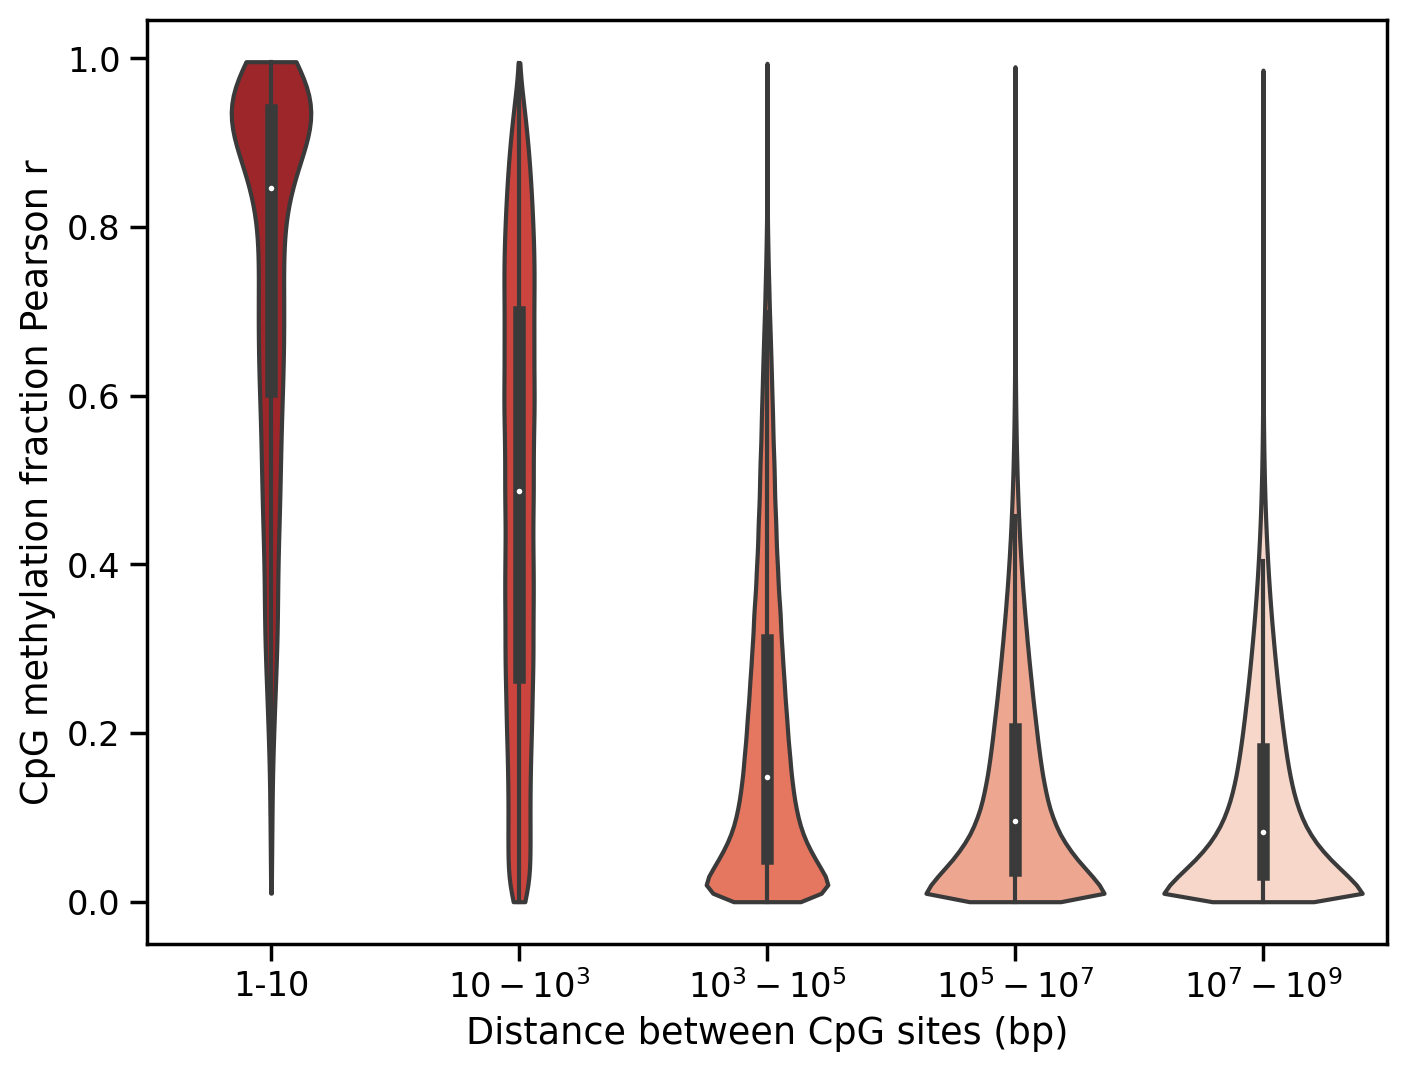

In [ ]:
utils.plot_corr_vs_dist(
    np.abs(chr1_corrs),
    chr1_dist_df.loc[chr1_corrs.index, chr1_corrs.columns],
    out_fn = os.path.join(fig_out_dir, 'figure4', 'fig4B_corrs_vs_dist_TCGA1.svg')
    )

#### ICGC

In [23]:
chr1_cpgs = illumina_cpg_locs_df.loc[illumina_cpg_locs_df['chr'] == '1', '#id'].values
chr1_w_methyl_cpgs = set(chr1_cpgs).intersection(set(icgc_methyl_age_df_t.columns))
chr1_dist_df = utils.get_distances_one_chrom_new('1', illumina_cpg_locs_df)

In [24]:
chr1_corrs_prad = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/final_icgc_data/chr_dset_corrs_qnorm/chr1_PRAD.parquet')

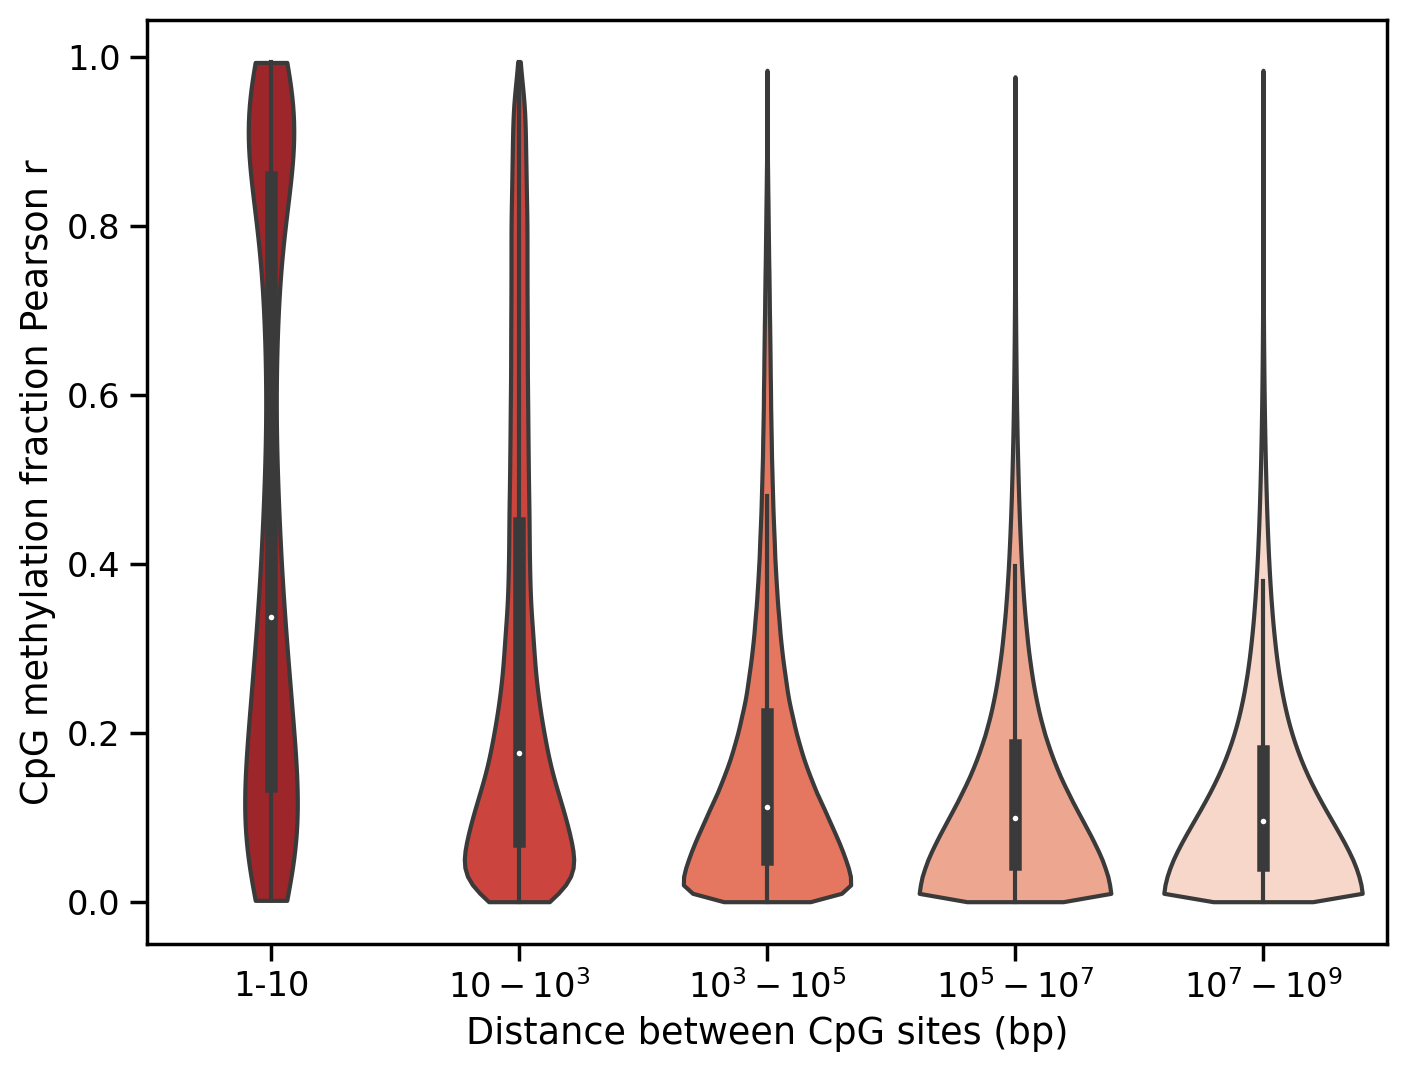

In [25]:
utils.plot_corr_vs_dist(
    np.abs(chr1_corrs_prad), 
    chr1_dist_df.loc[chr1_corrs_prad.index, chr1_corrs_prad.columns],
    out_fn = os.path.join(fig_out_dir, 'figure4', 'fig4B_prad_corrs_vs_dist_PRAD1.svg')
    )

# C) Supernova heatmap

0 1 1


/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:1012: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2 = ax.twinx()


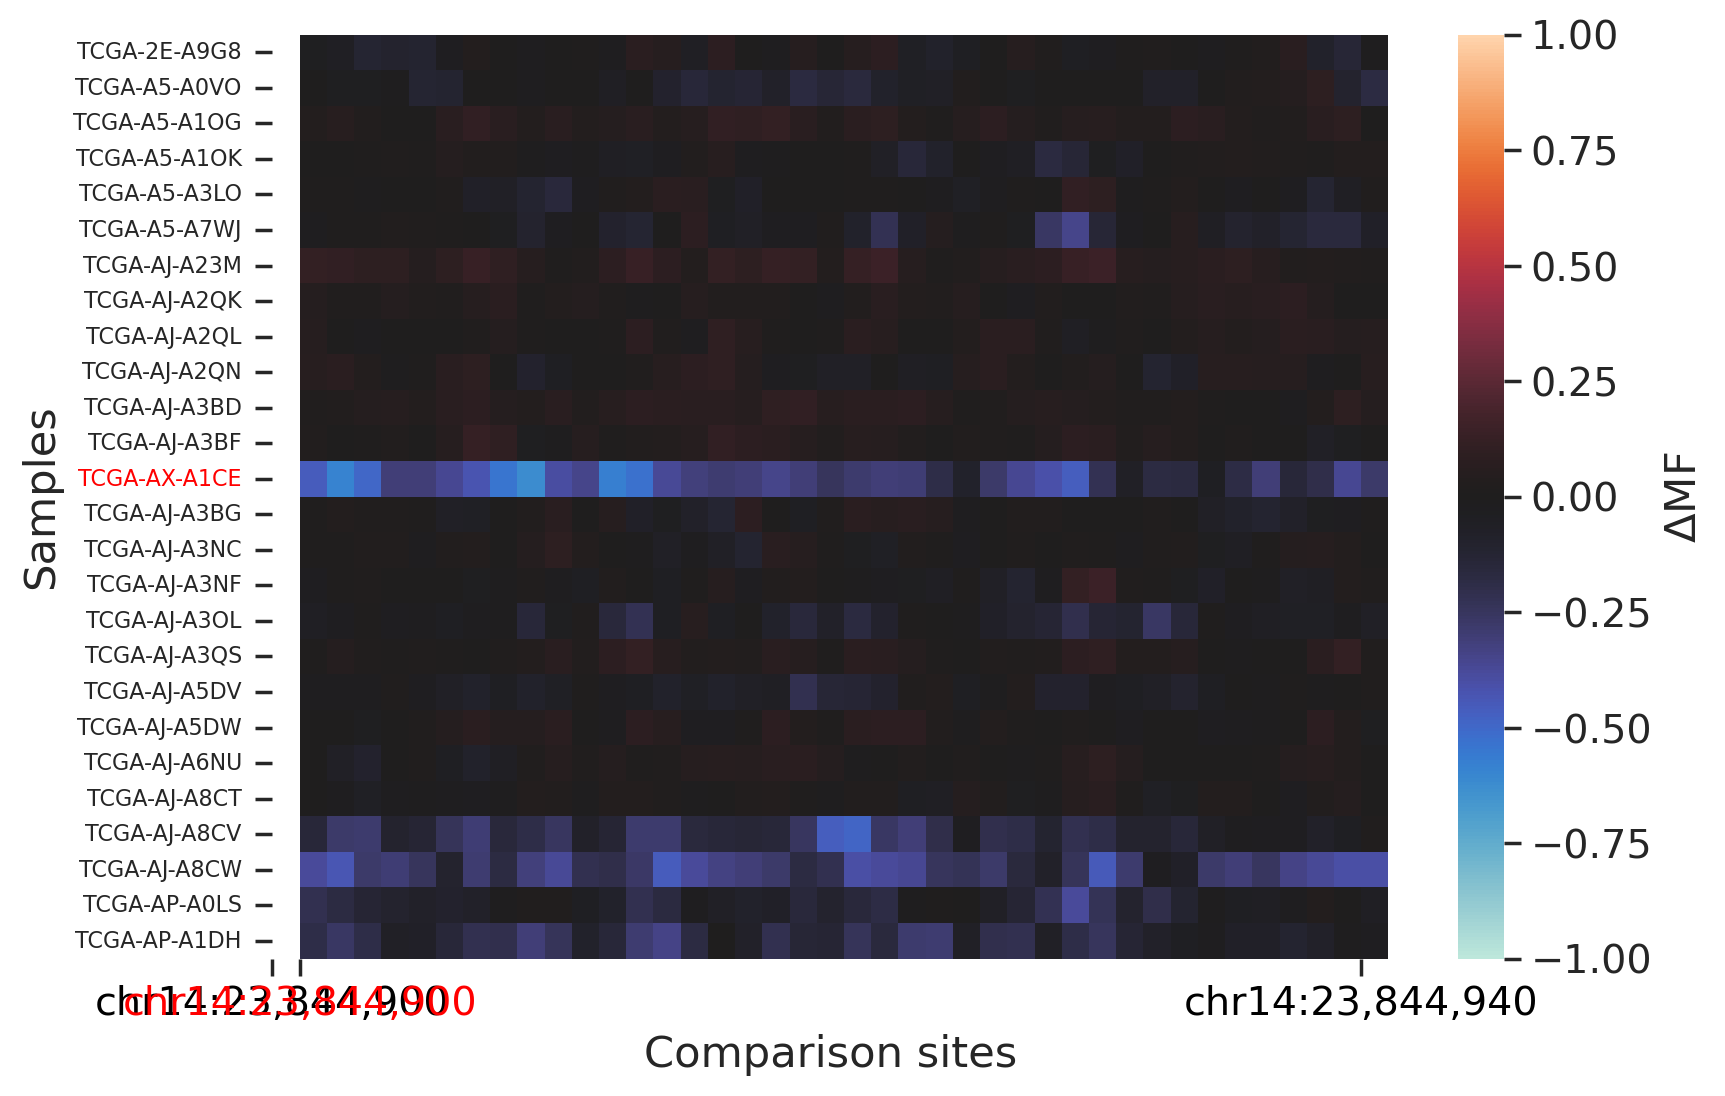

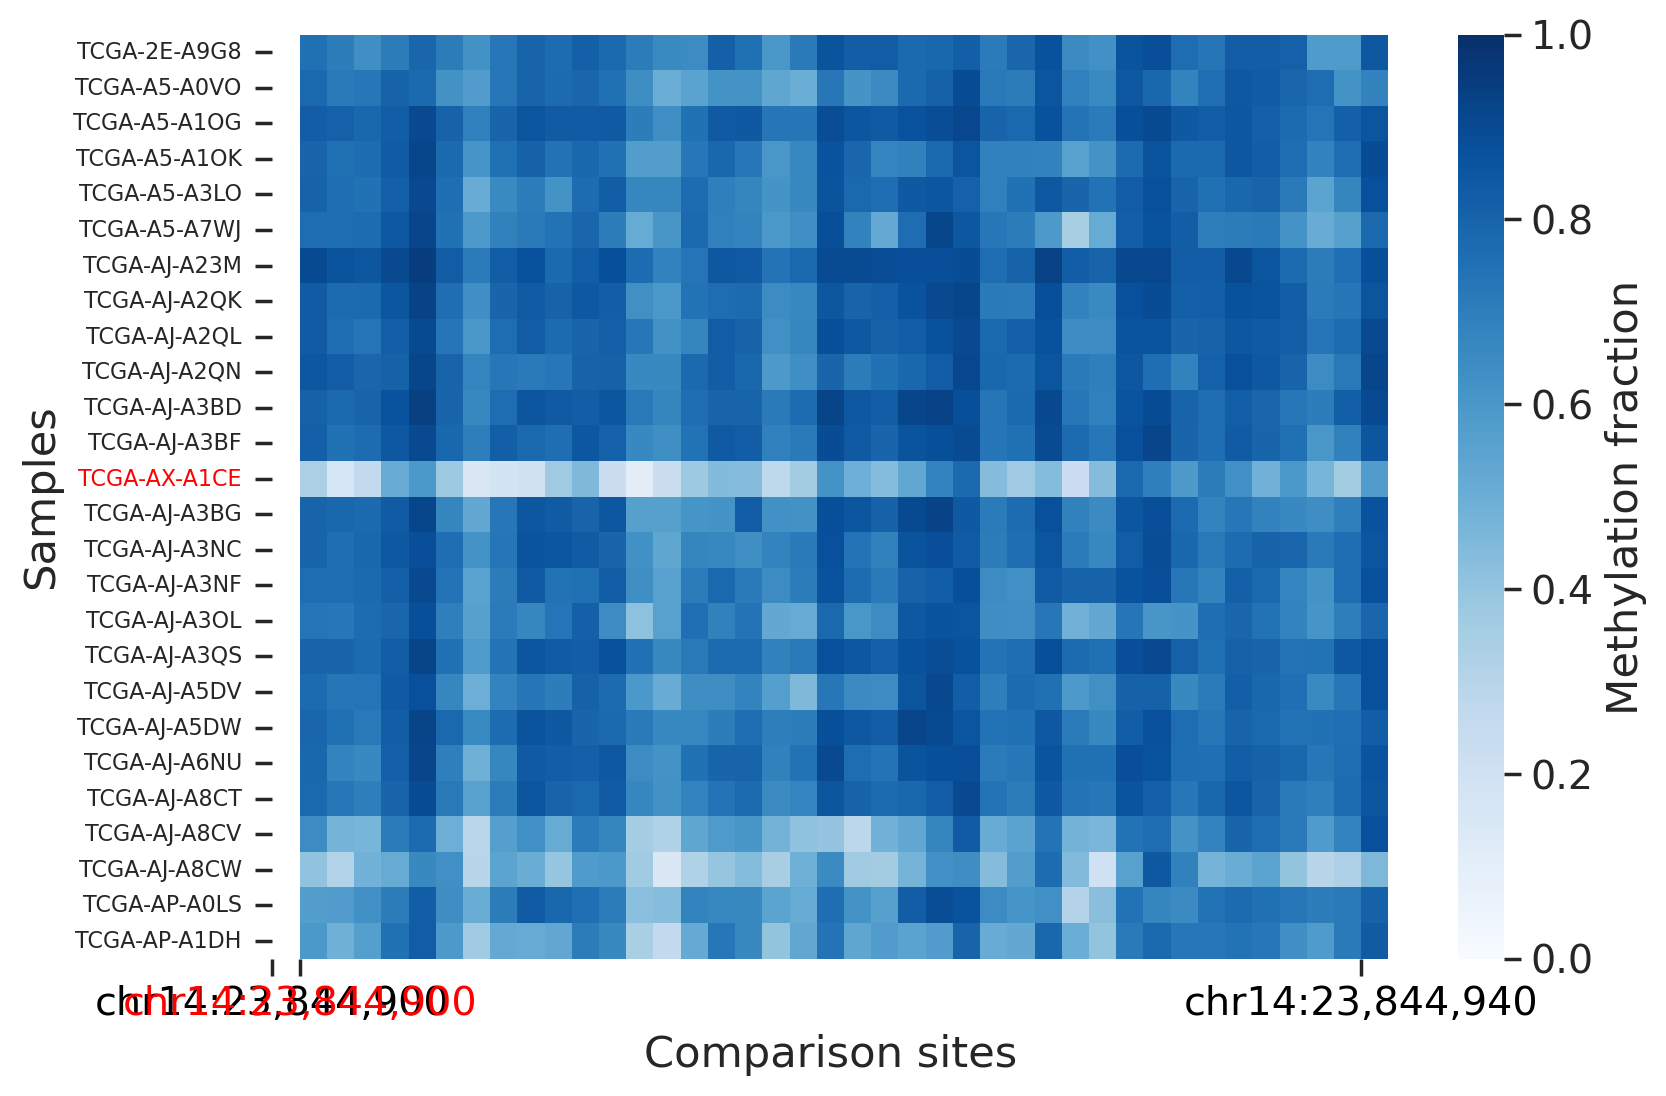

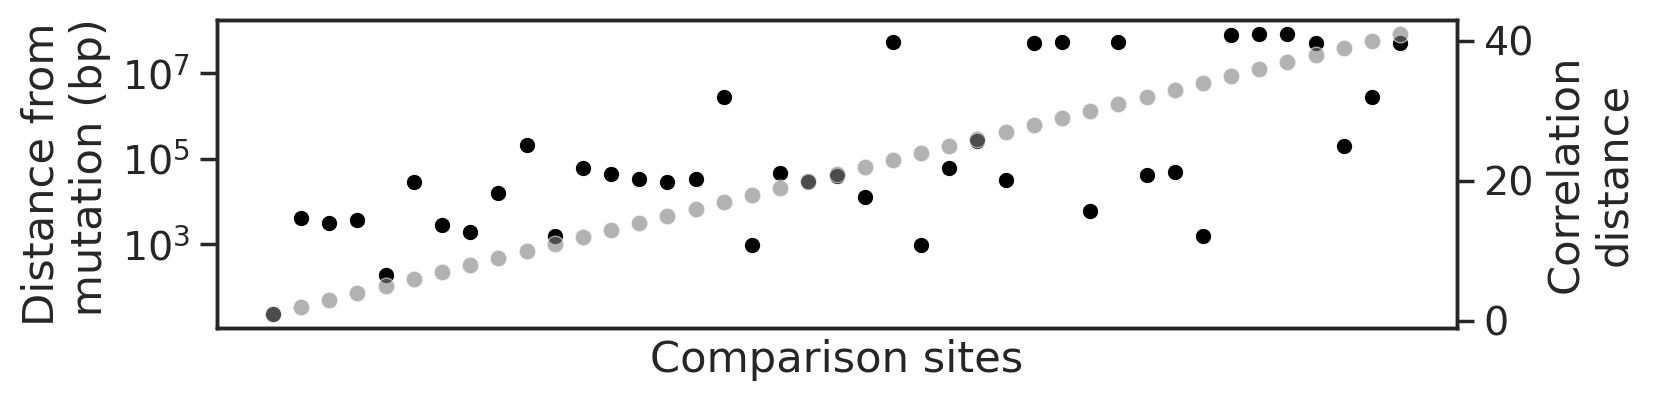

In [34]:
# best:TCGA-AX-A1CE_14:23844900	w/ max_abs_distance = 60 and max_matched_samples = 30
all_samples_comp_sites, all_samples_comp_sites_dmf, comparison_site_and_distances = analyze_comethylation.plot_heatmap_dist(
    mut_event = "TCGA-AX-A1CE_14:23844900",
    comparison_sites_df = corr_all_comparison_site_df,all_methyl_age_df_t = all_methyl_age_df_t, 
    illumina_cpg_locs_df = illumina_cpg_locs_df, method = 'corr',
    max_abs_distance = 40, max_matched_samples = 25, rolling_window_size = 2
)

# D) Disturbance by functional region

In [18]:
# make second axes bigger kw
fig, axes = plt.subplots(2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True)
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    icgc_corr_mean_metrics_w_annot_df,
    metric = 'median_dmf', axes = axes,
    consortium = 'ICGC', out_fn = os.path.join(fig_out_dir, 'figure4', 'figure4D_icgc_median_dmf_kdeplot.pdf')
    )

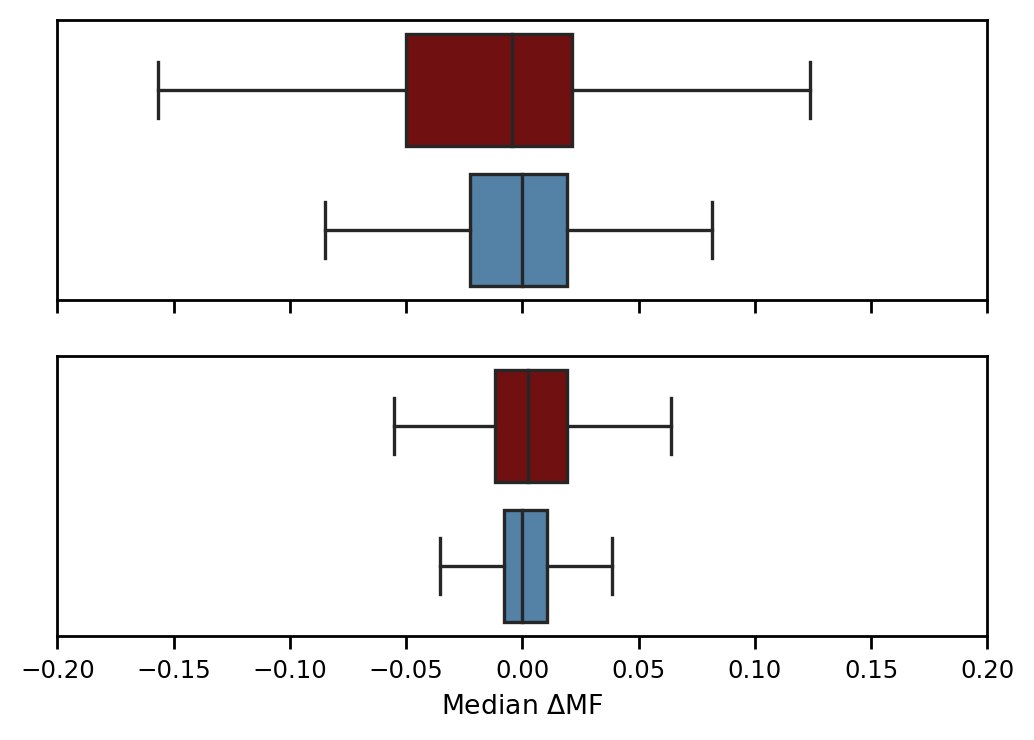

In [42]:
# 5
# make second axes bigger kw
fig, axes = plt.subplots(2,1, figsize = (6, 4), dpi = 100, sharex='col')
axes = axes.flatten()
sns.set_context('paper')
###############################################################
# all
###############################################################
# do not show x or y ticks or labels

icgc_corr_mean_metrics_w_annot_df['is_cpg'] = icgc_corr_mean_metrics_w_annot_df['seq'].str.upper().str.contains('CG')
icgc_corr_mean_metrics_w_annot_df['is_cpg'] = icgc_corr_mean_metrics_w_annot_df['is_cpg'].map({True: 'CpG', False: 'Non-CpG'})

icgc_corr_mean_metrics_w_annot_df['is_cgi_renamed'] = icgc_corr_mean_metrics_w_annot_df['is_cgi'].map({True: 'in CGI', False: 'not in CGI'})

icgc_corr_mean_metrics_w_annot_df['combined_category'] = icgc_corr_mean_metrics_w_annot_df['is_cpg'] + '\n' + icgc_corr_mean_metrics_w_annot_df['is_cgi_renamed']

mut = icgc_corr_mean_metrics_w_annot_df.loc[icgc_corr_mean_metrics_w_annot_df.mutated_sample == True]
mut = mut.rename(
    columns={'is_background': 'Locus'}
    ).replace(
                {'Locus': {True: 'Random', False: 'Mutated'}}
                )
        

bins = np.linspace(-.75, .75, 28)
sns.boxplot(
    data=mut.query("is_cgi == False"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[0], showfliers=False, order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

sns.boxplot(
    data=mut.query("is_cgi == True"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[1], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

axes[1].set_xlim(-.2, .2)
for i in range(2):
    axes[i].set_yticklabels([])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticks([])
axes[1].set_xlabel('Median $\Delta$MF')
plt.savefig(os.path.join(fig_out_dir, 'figure4', 'figure4D_icgc_median_dmf_boxplots.svg'), format='svg', dpi = 300)


# E) Corr distance vs. genomic distance

In [21]:
bg_biggest_pos_to_plot_w_genomic_dist

,#id,chr,measured_start,Strand,delta_mf_median,mutated_sample,mut_event,is_background,index_event,measured_site,measured_site_dist,mut_start,genomic_dist,abs_genomic_dist
0,cg18368637,6,144179905,R,-0.289594,True,DO46602_6:166944768,True,DO46602_19:51145609,cg18368637,0,166944768,22764863,22764863
1,cg21093166,5,2752145,F,-0.203817,True,DO46356_5:2752139,True,DO46356_7:127911258,cg21093166,0,2752139,-6,6
2,cg01566552,19,18977814,F,0.118285,True,DO46602_19:18977405,True,DO46602_19:51145609,cg01566552,0,18977405,-409,409
3,cg18438319,7,155333384,F,0.090328,True,DO46602_7:156807474,True,DO46602_19:51145609,cg18438319,0,156807474,1474090,1474090
4,cg10085326,11,102826680,F,-0.478690,True,DO46602_11:19940827,True,DO46602_19:51145609,cg10085326,0,19940827,-82885853,82885853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,cg02467765,4,78978708,F,0.024761,True,DO46356_4:81105355,True,DO46356_7:127911258,cg02467765,166,81105355,2126647,2126647
499996,cg13253303,11,134126080,F,0.016087,True,DO46483_11:100999399,True,DO46483_1:38510933,cg13253303,166,100999399,-33126681,33126681
499997,cg27517502,10,1248770,F,-0.013913,True,DO46342_10:49743842,True,DO46342_10:134807902,cg27517502,166,49743842,48495072,48495072
499998,cg11510714,22,32768291,F,-0.005921,True,DO46356_22:20810155,True,DO46356_2:2605398,cg11510714,166,20810155,-11958136,11958136


In [19]:
def median_constant_obs_per_window(df, N, distance_metric = 'measured_site_dist'):
    """
    @ df: dataframe with columns 'measured_site_dist' and 'delta_mf_median'
    @ N: number of rows to use for each window
    @ distance_metric: column name to use for distance metric
    """
    # sort by distance, so rows are in order of increasing distance from mutation
    df = df.sort_values(by = distance_metric, ascending = True).reset_index(drop = True)
    # rolling window median of delta_mf_median of size N
    # so N rows are used to calculate the median for each window
    df['rolling_median'] = df.rolling(window = N)['delta_mf_median'].median()
    return df

(<Figure size 1000x600 with 4 Axes>,
 array([<Axes: xlabel='Correlation distance (rank order)', ylabel='$\\Delta$MF'>,
        <Axes: xlabel='Genomic distance (kb)'>,
        <Axes: xlabel='Correlation distance (rank order)', ylabel='$\\Delta$MF'>,
        <Axes: xlabel='Genomic distance (kb)'>], dtype=object))

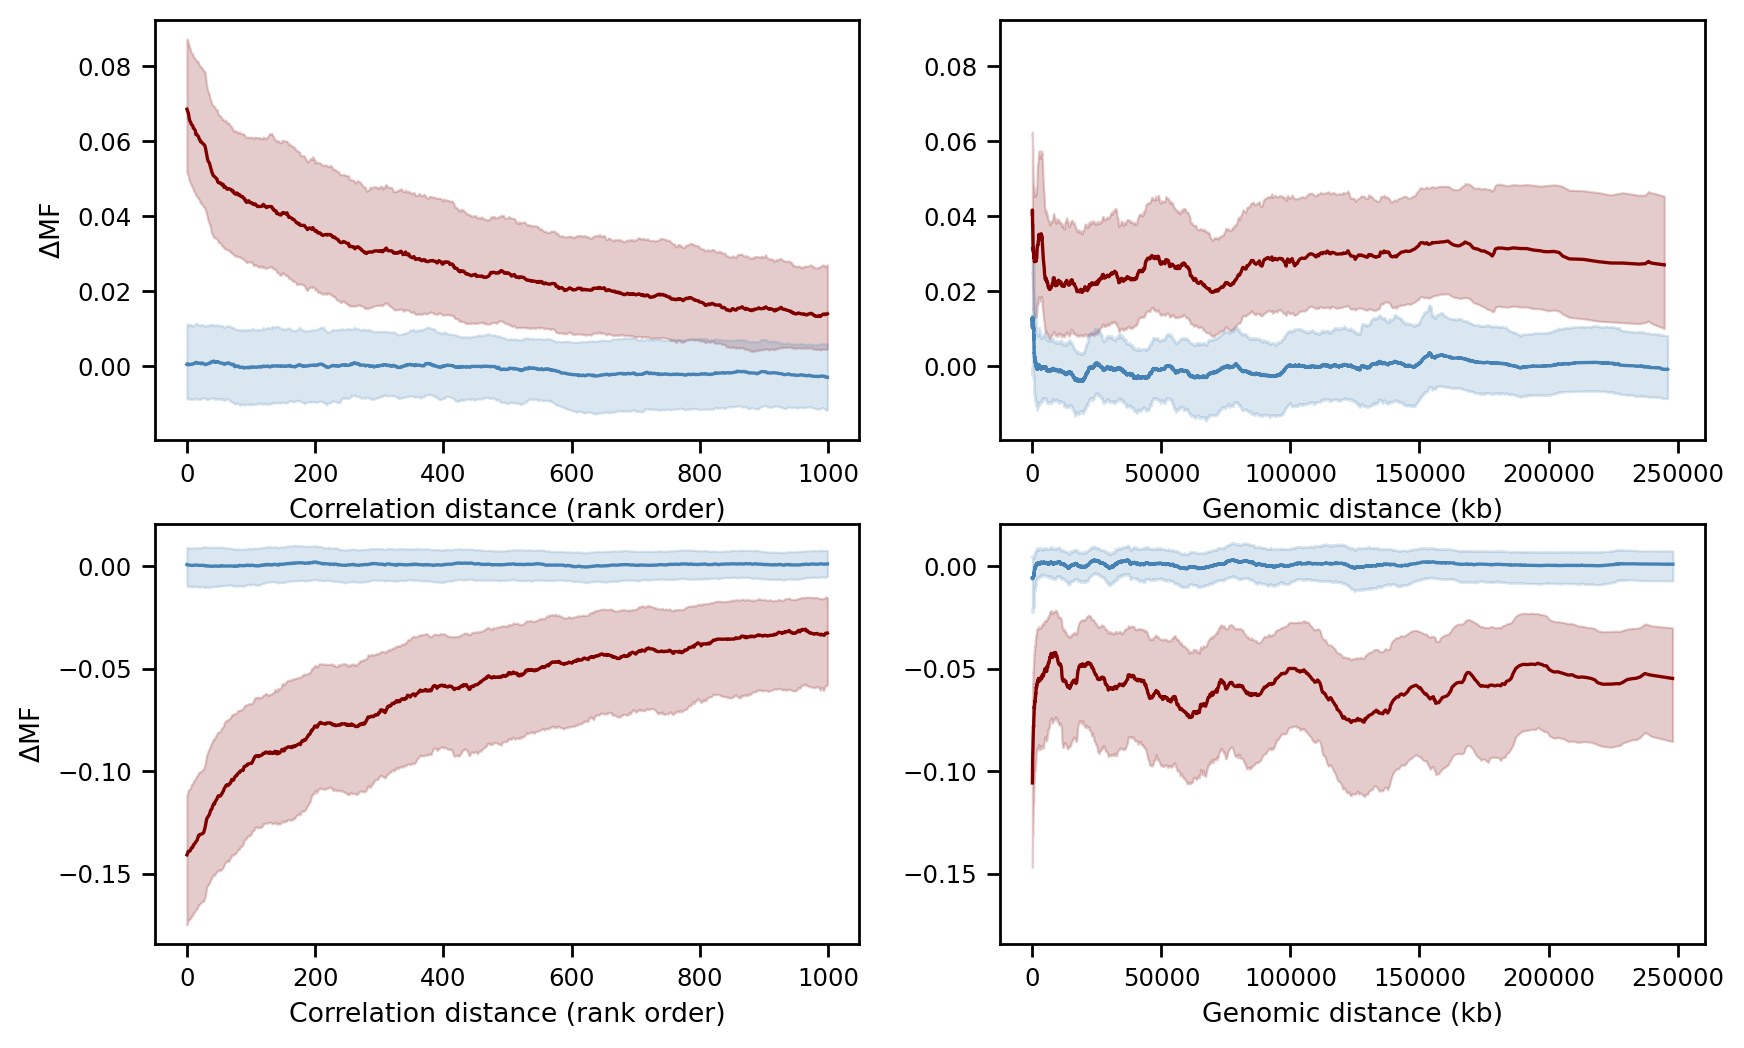

In [45]:
# there are num_top_muts * 1000 rows = 138,000
# and num_top_muts rows for each correlation distance value
# so 10,000 is 
analyze_comethylation.plot_distance_of_effect_lineplot(
    icgc_corr_mean_metrics_df, icgc_corr_all_metrics_df, num_top_muts = 138,
    smoothing_window_size_corr = 6900, # num_top_muts * 50
    smoothing_window_size_dist = 6900, 
    dist = 10, plot_bg = True, out_fn = os.path.join(fig_out_dir, 'figure4', 'figure4E_icgc_distance_of_effect_corr_vs_dist.svg'), corr_vs_dist = True,
    illumina_cpg_locs_df = illumina_cpg_locs_df
    )